In [1]:
# %%
import sys
sys.path.append('/public/src')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from factor_evaluation_server import FactorEvaluation, DataService

# 初始化数据服务
ds = DataService()
df = ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

# 读取已有因子数据
factor_path = "/public/data/factor_data/ETHUSDT_15m_2020_2025_factor_data.pkl"
factors = pd.read_pickle(factor_path)

# 检查是否有时间索引，如果有则重置为整数索引
if isinstance(factors.index, pd.DatetimeIndex) or factors.index.dtype == 'datetime64[ns]':
    factors = factors.reset_index(drop=True)

# 保存原始列名（旧因子）
original_columns = factors.columns.tolist()
print(f"加载了 {len(original_columns)} 个旧因子")

加载了 141 个旧因子


In [2]:
def factor(df, window=94):
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 向量化计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 2. 向量化重心计算
    def vectorized_center(group, direction):
        dir_col = f'is_{direction}'
        # 获取分组索引和权重
        idx = group.index
        weights = group['fractal'] * group['volume']
        mask = (group[dir_col] == 1)
        
        # 向量化计算
        cum_weights = weights.where(mask, 0).cumsum()
        cum_weighted_idx = (pd.Series(range(len(group)), index=idx)
                          .where(mask, 0) * weights).cumsum()
        
        # 计算重心并处理边界条件
        center = cum_weighted_idx / cum_weights
        center.iloc[:4] = np.nan  # 前4个点不计算
        return center
    
    # 按日分组并行计算
    df['G_u'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'up'))
                 .reset_index(level=0, drop=True))
    
    df['G_d'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'down'))
                 .reset_index(level=0, drop=True))
    
    # 3. 滚动窗口向量化
    df['avg_fractal'] = df['fractal'].rolling(24, min_periods=12).mean()
    
    # 预计算有效索引
    valid_idx = df.dropna(subset=['G_u', 'G_d', 'avg_fractal']).index
    regression_data = np.full(len(df), np.nan)
    
    # 4. 滚动回归优化
    # 预计算累积矩阵 (X'X 和 X'y)
    X = df[['G_u', 'avg_fractal']].values
    y = df['G_d'].values
    
    # 初始化存储
    XTX = np.zeros((len(df), 2, 2))
    XTy = np.zeros((len(df), 2))
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    
    # 批量计算外积
    for i in range(len(df)):
        if valid_mask[i]:
            x_vec = X[i]
            XTX[i] = np.outer(x_vec, x_vec)
            XTy[i] = x_vec * y[i]
    
    # 计算累积和
    cum_XTX = np.nancumsum(XTX, axis=0)
    cum_XTy = np.nancumsum(XTy, axis=0)
    
    # 5. 向量化滚动回归
    for i in range(window, len(df)):
        start = i - window
        
        # 使用累积差计算窗口矩阵
        window_XTX = cum_XTX[i-1] - (cum_XTX[start-1] if start > 0 else 0)
        window_XTy = cum_XTy[i-1] - (cum_XTy[start-1] if start > 0 else 0)
        
        # 检查有效数据点数
        window_points = np.count_nonzero(valid_mask[start:i])
        if window_points < 10:
            continue
            
        try:
            # 求解线性方程组
            coeffs = np.linalg.solve(window_XTX, window_XTy)
            pred = X[i] @ coeffs
            residual = y[i] - pred
            regression_data[i] = residual * df['avg_fractal'].iloc[i]
        except np.linalg.LinAlgError:
            continue
    
    # 6. 后处理
    factor_series = pd.Series(-regression_data, index=df.index)
    return factor_series.fillna(0)

In [3]:
# 所有新因子计算函数的映射
factor_calculators = {
    '250709_时间重心偏离_分形市场_快': factor
}

In [4]:
# 计算并添加所有新因子
print("\n开始计算新因子...")
for factor_name, calculator in tqdm(factor_calculators.items(), desc="计算因子"):
    try:
        # 计算因子值并转换为pandas Series
        factor_values = calculator(df)
        if isinstance(factor_values, pd.Series):
            # 确保长度与factors一致
            if len(factor_values) != len(factors):
                # 截断或填充以匹配长度
                factor_values = factor_values.iloc[:len(factors)].reset_index(drop=True)
            factors[factor_name] = factor_values.values
        else:
            # 处理numpy数组
            if len(factor_values) != len(factors):
                factor_values = factor_values[:len(factors)]
            factors[factor_name] = factor_values
    except Exception as e:
        print(f"计算因子 {factor_name} 时出错: {str(e)}")
        # 添加空列以保持数据结构
        factors[factor_name] = np.nan

# 确保索引对齐
factors = factors.reset_index(drop=True)


开始计算新因子...


计算因子: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


In [5]:
# 计算相关系数矩阵
print("\n计算相关系数矩阵...")
corr_matrix = factors.corr()

# 提取新因子与旧因子的相关系数
new_factors = list(factor_calculators.keys())
old_factors = original_columns
new_to_old_corr = corr_matrix.loc[new_factors, old_factors]


计算相关系数矩阵...


In [14]:
# 设置相关性阈值
threshold = 0.4
high_corr_records = []  # 用于存储高相关性记录

print(f"\n高相关性因子分析 (新因子与旧因子, |corr| > {threshold}):")
for new_factor in new_factors:
    # 只考虑与旧因子的相关性
    corr_series = new_to_old_corr.loc[new_factor]
    
    # 找出相关性绝对值超过阈值的因子
    high_corr = corr_series[abs(corr_series) > threshold]
    
    if not high_corr.empty:
        print(f"\n🔍 {new_factor} 与以下旧因子有高相关性:")
        for factor, corr_value in high_corr.items():
            # 判断相关性强弱和方向
            strength = "强" if abs(corr_value) > 0.8 else "中等"
            direction = "正" if corr_value > 0 else "负"
            
            print(f"  - {factor}: {corr_value:.4f} ({strength}{direction}相关)")
            high_corr_records.append({
                '新因子': new_factor,
                '旧因子': factor,
                '相关系数': corr_value,
                '相关强度': strength,
                '相关方向': direction
            })


高相关性因子分析 (新因子与旧因子, |corr| > 0.4):

🔍 250709_时间重心偏离_分形市场_快 与以下旧因子有高相关性:
  - c_chu006: 0.4080 (中等正相关)
  - c_chu053: 0.4028 (中等正相关)


In [15]:
# 在Notebook中直接显示高相关性因子表格
if high_corr_records:
    high_corr_df = pd.DataFrame(high_corr_records)
    
    # 美化显示表格
    print("\n📊 高相关性因子汇总表 (新因子 vs 旧因子):")
    display(high_corr_df[['新因子', '旧因子', '相关系数', '相关强度', '相关方向']]
            .sort_values(by='相关系数', key=abs, ascending=False)
            .style
            .background_gradient(cmap='coolwarm', subset=['相关系数'])
            .format({'相关系数': "{:.4f}"})
            .set_caption(f"高相关性因子汇总 (|corr| > {threshold})"))
else:
    print(f"\n✅ 未发现高相关性新因子与旧因子 (|corr| > {threshold})")


📊 高相关性因子汇总表 (新因子 vs 旧因子):


,新因子,旧因子,相关系数,相关强度,相关方向
0,250709_时间重心偏离_分形市场_快,c_chu006,0.4080,中等,正
1,250709_时间重心偏离_分形市场_快,c_chu053,0.4028,中等,正


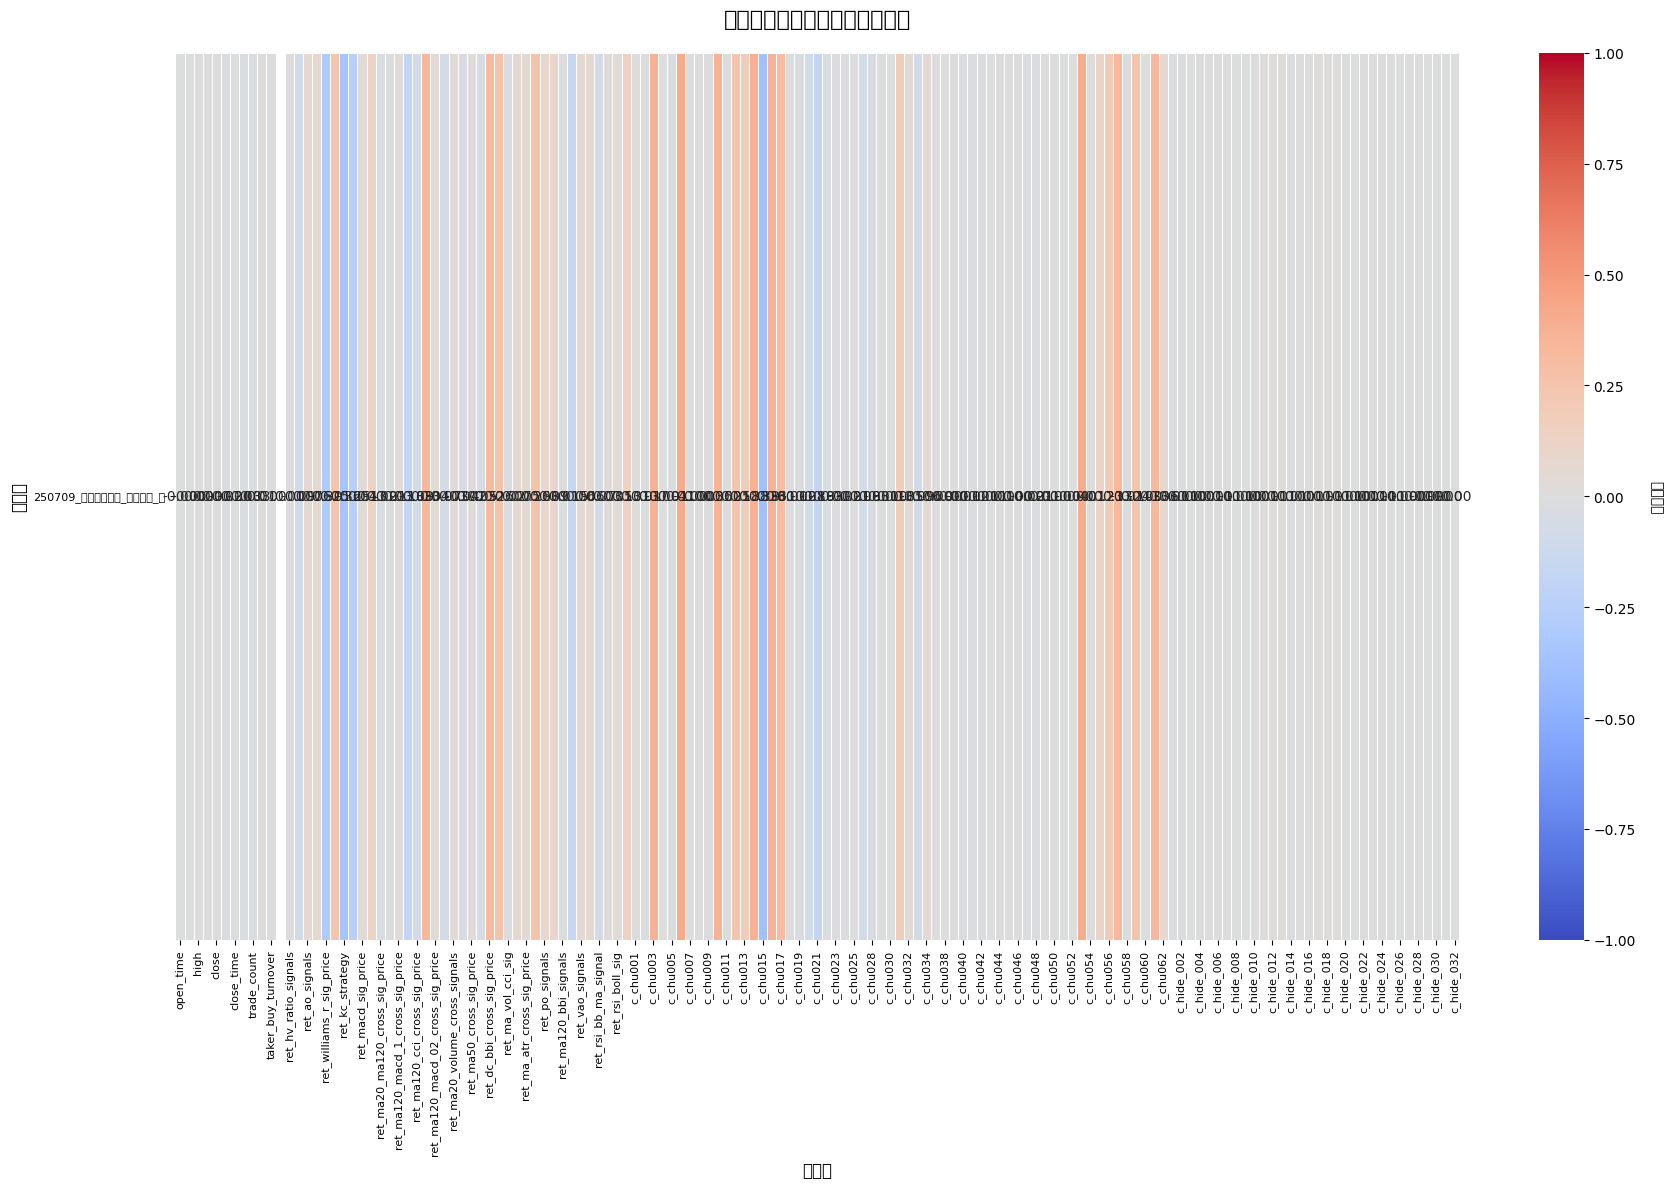

In [16]:
# 可视化：新因子与旧因子的相关性热力图
plt.figure(figsize=(18, 12))
sns.heatmap(
    new_to_old_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title('新因子与旧因子的相关性热力图', fontsize=16, pad=20)
plt.xlabel('旧因子', fontsize=12)
plt.ylabel('新因子', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# 添加颜色条说明
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('相关系数', rotation=270, labelpad=20)

# 直接在Notebook中显示图表
plt.tight_layout()
plt.show()

In [17]:
# 加载同质异质分离数据（如果存在）
homo_hetero_path = "/public/data/factor_data/ETHUSDT_15m_2020_2025_homo_heter_split.joblib"
if os.path.exists(homo_hetero_path):
    try:
        homo_hetero_data = joblib.load(homo_hetero_path)
        print("\n加载同质异质分离数据成功!")
        # 这里可以添加对同质异质数据的分析代码
    except Exception as e:
        print(f"\n加载同质异质分离数据时出错: {str(e)}")
else:
    print("\n未找到同质异质分离数据文件")

print("\n🎉 因子相关性分析完成!")


加载同质异质分离数据成功!

🎉 因子相关性分析完成!
